[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


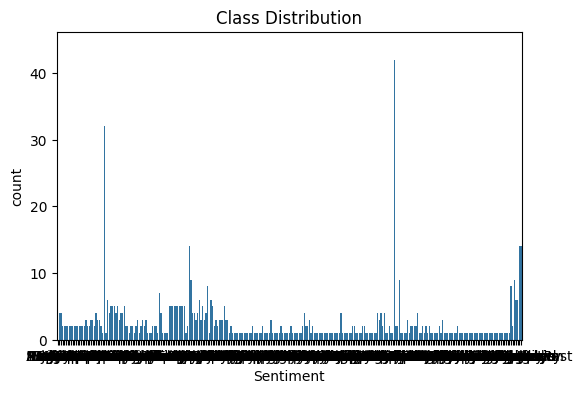

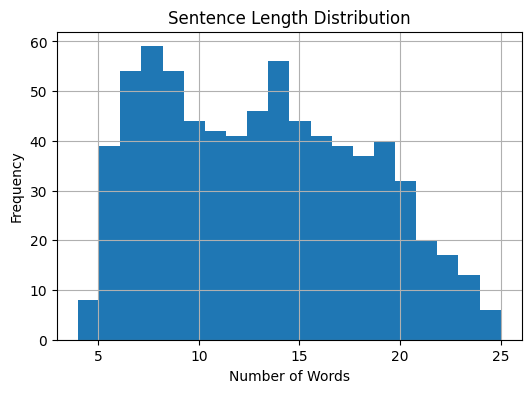

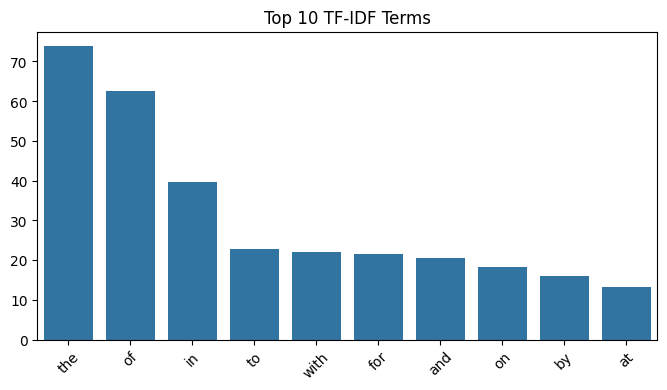

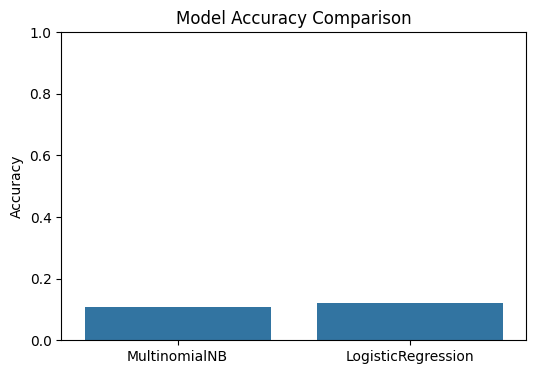

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

MultinomialNB Classification Report:
                         precision    recall  f1-score   support

         Acceptance          0.00      0.00      0.00         2
           Admiration        0.00      0.00      0.00         1
        Admiration           0.00      0.00      0.00         1
         Affection           0.00      0.00      0.00         1
      Ambivalence            0.00      0.00      0.00         1
         Anger               0.00      0.00      0.00         1
        Anticipation         0.00      0.00      0.00         1
        Arousal              0.00      0.00      0.00         3
                  Awe        0.00      0.00      0.00         1
         Awe                 0.00      0.00      0.00         1
                  Bad        0.00      0.00      0.00         1
             Betrayal        0.00      0.00      0.00         2
        Betrayal             0.00      0.00      0.00         1
         Bitter              0.00      0.00      0.00         1
 

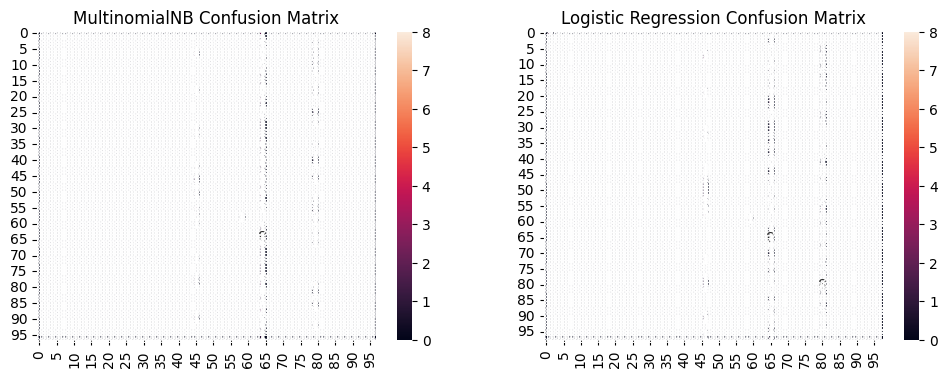

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import spacy

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

nlp = spacy.load("en_core_web_sm")

df = pd.read_csv('sentimentdataset.csv')

def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df['clean_text'] = df['Text'].apply(clean_text)
df['tokens'] = df['clean_text'].apply(nltk.word_tokenize)

stop_words = set(stopwords.words('english'))
df['tokens_nostop'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

lemmatizer = WordNetLemmatizer()
df['lemmatized'] = df['tokens_nostop'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Sentiment')
plt.title('Class Distribution')
plt.show()

df['sentence_length'] = df['clean_text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['word_count'] = df['lemmatized'].apply(len)
df['pos_tags'] = df['Text'].apply(lambda x: [(token.text, token.pos_) for token in nlp(x)])
df['named_entities'] = df['Text'].apply(lambda x: [(ent.text, ent.label_) for ent in nlp(x).ents])

plt.figure(figsize=(6,4))
df['sentence_length'].hist(bins=20)
plt.title('Sentence Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(df['clean_text'])

sum_words = X_tfidf.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in tfidf.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:10]
words, freqs = zip(*words_freq)

plt.figure(figsize=(8,4))
sns.barplot(x=list(words), y=list(freqs))
plt.title("Top 10 TF-IDF Terms")
plt.xticks(rotation=45)
plt.show()

X = X_tfidf
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model1 = MultinomialNB()
model2 = LogisticRegression(max_iter=1000)

model1.fit(X_train, y_train)
model2.fit(X_train, y_train)

pred1 = model1.predict(X_test)
pred2 = model2.predict(X_test)

acc1 = accuracy_score(y_test, pred1)
acc2 = accuracy_score(y_test, pred2)

plt.figure(figsize=(6,4))
sns.barplot(x=["MultinomialNB", "LogisticRegression"], y=[acc1, acc2])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

print("MultinomialNB Classification Report:\n", classification_report(y_test, pred1))
print("Logistic Regression Classification Report:\n", classification_report(y_test, pred2))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(confusion_matrix(y_test, pred1), annot=True, fmt='d', ax=axes[0])
axes[0].set_title("MultinomialNB Confusion Matrix")

sns.heatmap(confusion_matrix(y_test, pred2), annot=True, fmt='d', ax=axes[1])
axes[1].set_title("Logistic Regression Confusion Matrix")
plt.show()

if len(df['Sentiment'].unique()) == 2:
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_test_bin = le.fit_transform(y_test)
    probs = model2.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test_bin, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
